In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import cv2
import gc
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras import layers


In [3]:
!pip install opendatasets
!pip install pandas

In [4]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryany10
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


In [17]:
path = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_scc', 'lung_aca', 'lung_n']

In [19]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define image parameters
IMG_SIZE = 256
BATCH_SIZE = 64

# Load the dataset
train_dataset = image_dataset_from_directory(
    path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Splitting 20% for validation
    subset="training",
    seed=42,
    label_mode='categorical'  # For multi-class classification
)

# Extract class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)

print("Class Names:", class_names)
print("Number of Classes:", num_classes)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Class Names: ['lung_aca', 'lung_n', 'lung_scc']
Number of Classes: 3


In [23]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from tensorflow.keras import Sequential

# Define Data Augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomBrightness(0.1)
])

# Define image parameters
IMG_SIZE = 256
BATCH_SIZE = 64

# Load the dataset with augmentation
train_dataset = image_dataset_from_directory(
    path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='categorical'
)  # Apply augmentation


# Extract class names before applying map
class_names = train_dataset.class_names
num_classes = len(class_names)

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Load validation dataset (No augmentation)
val_dataset = image_dataset_from_directory(
    path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='categorical'
)


print("Class Names:", class_names)
print("Number of Classes:", num_classes)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Class Names: ['lung_aca', 'lung_n', 'lung_scc']
Number of Classes: 3


In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load ResNet50 without the top layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation="relu")(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Reduce overfitting
output_layer = Dense(num_classes, activation="softmax")(x)  # Output layer

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate adjustment callback
learnspeed = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model for a fixed number of epochs
EPOCHS = 15  # Set the number of epochs you want

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[learnspeed]
)


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.9043 - loss: 0.2390 - val_accuracy: 0.9677 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9633 - loss: 0.0926 - val_accuracy: 0.9807 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9744 - loss: 0.0692 - val_accuracy: 0.9760 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9722 - loss: 0.0658 - val_accuracy: 0.9490 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9737 - loss: 0.0639 - val_accuracy: 0.9870 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9781 - loss: 0.0516 - val_accuracy: 0.9797 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9800 - loss: 0.

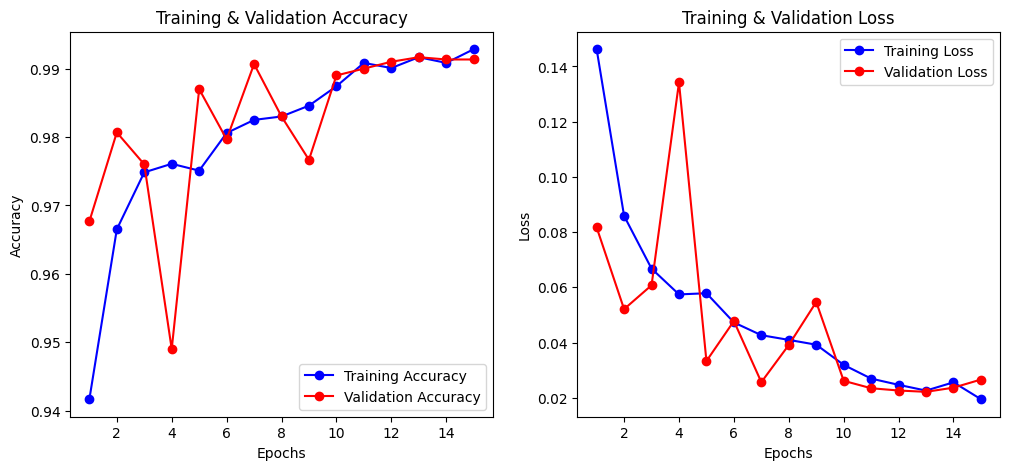

In [26]:
import matplotlib.pyplot as plt

# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

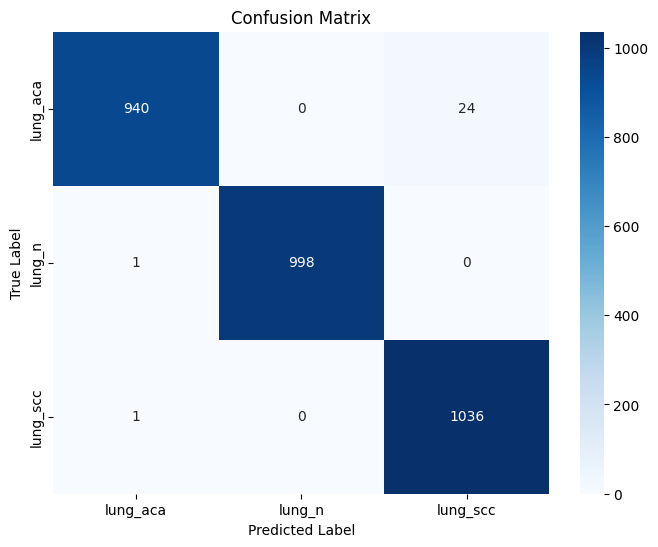

              precision    recall  f1-score   support

    lung_aca       1.00      0.98      0.99       964
      lung_n       1.00      1.00      1.00       999
    lung_scc       0.98      1.00      0.99      1037

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_pred.extend(np.argmax(preds, axis=1))  # Convert to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to indices

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get class labels (assuming your dataset has class names)
#class_labels = list(train_dataset.class_names) # train_dataset is a _MapDataset object and does not have the class_names attribute
class_labels = class_names # Use the class_names variable that was defined earlier

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))